In [59]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Common libs
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
# # Image processing
import imageio
import cv2
import skimage.transform
#from skimage.transform import rescale, resize, downscale_local_mean
# Charts
import matplotlib.pyplot as plt
import seaborn as sns

# ML, statistics
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score


# Tensorflow
#from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [70]:
image_size = (160, 160)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 6805 files belonging to 2 classes.
Using 5444 files for training.
Found 6805 files belonging to 2 classes.
Using 1361 files for validation.


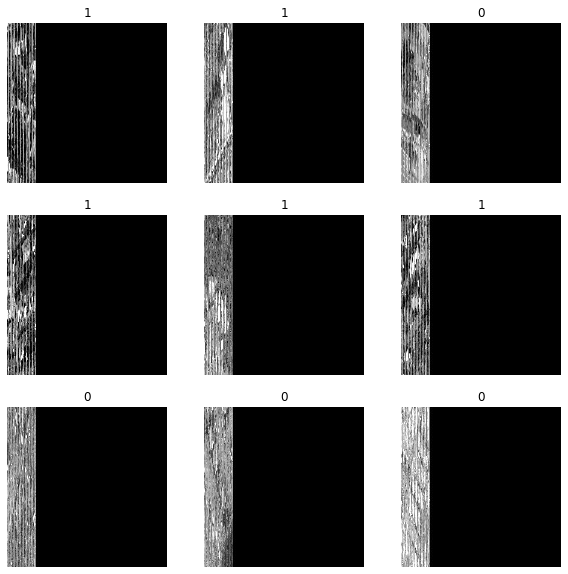

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [72]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

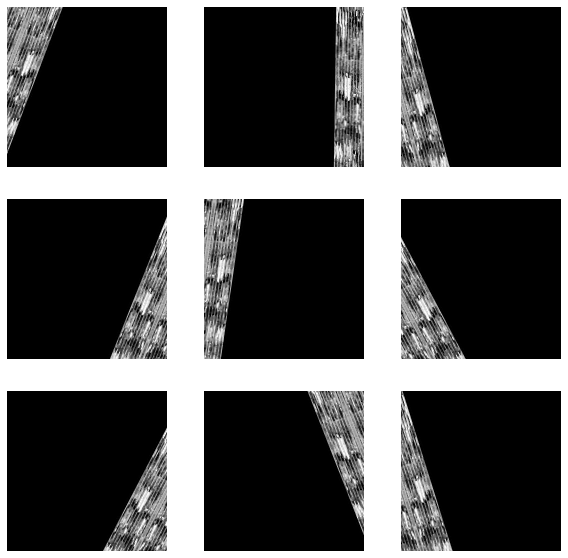

In [73]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [75]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [76]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [77]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
171/171 [==============================] - 186s 1s/step - loss: 0.7117 - accuracy: 0.5954 - val_loss: 0.8880 - val_accuracy: 0.4989
Epoch 2/50
171/171 [==============================] - 183s 1s/step - loss: 0.5629 - accuracy: 0.7295 - val_loss: 1.1958 - val_accuracy: 0.4989
Epoch 3/50
171/171 [==============================] - 183s 1s/step - loss: 0.4957 - accuracy: 0.7638 - val_loss: 0.6675 - val_accuracy: 0.5077
Epoch 4/50
171/171 [==============================] - 183s 1s/step - loss: 0.4650 - accuracy: 0.7744 - val_loss: 0.5790 - val_accuracy: 0.6929
Epoch 5/50
171/171 [==============================] - 183s 1s/step - loss: 0.4820 - accuracy: 0.7640 - val_loss: 1.3269 - val_accuracy: 0.5305
Epoch 6/50
171/171 [==============================] - 182s 1s/step - loss: 0.4587 - accuracy: 0.7740 - val_loss: 0.6669 - val_accuracy: 0.5716
Epoch 7/50
171/171 [==============================] - 185s 1s/step - loss: 0.4503 - accuracy: 0.7753 - val_loss: 0.5710 - val_accuracy: 0.6503

In [85]:
img = keras.preprocessing.image.load_img(
#      "dataset/washed/2_____B_4_2_303_314_316_1000_0001.jpg", target_size=image_size
#     "dataset/unwashed/1_____B_4_2_303_314_316_1005_0001.jpg", target_size=image_size

   
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent unwashed and %.2f percent washed."
    % (100 * (1 - score), 100 * score)
)

This image is 99.83 percent unwashed and 0.17 percent washed.
